In [1]:
# Importar librerías necesarias
import pandas as pd
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

# Habilitar conversión entre pandas y R
pandas2ri.activate()

In [2]:
from rpy2.robjects.packages import importr

# Cargar el paquete base de R
base = importr('base')

In [3]:
# Verificar conexión con R e intentar cargar un paquete
utils = importr('utils')  # Librería para gestionar paquetes en R

try:
    depmixS4 = importr('depmixS4')  # Intentar cargar depmixS4
    print("El paquete 'depmixS4' se cargó correctamente.")
except:
    print("El paquete 'depmixS4' no está instalado. Procediendo a instalar...")
    utils.install_packages('depmixS4')
    depmixS4 = importr('depmixS4')
    print("El paquete 'depmixS4' se instaló y cargó correctamente.")

El paquete 'depmixS4' se cargó correctamente.


In [4]:
import os
# os.environ["R_HOME"] = r"C:\Program Files\R\R-4.5.0"  # Change this path according to your R installation.

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

import seaborn as sns
import numpy as np
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import IntVector

# Enable conversion between pandas and R
pandas2ri.activate()

# Load the R base package
base = importr('base')
# Load the package depmixS4
depmixS4 = importr("depmixS4")
# Set the seed in R for reproducibility
r('set.seed(2030)')
# Set seed in Python for reproducibility
np.random.seed(2030)

In [5]:
covid_data = pd.read_excel('/Users/constanzaneiraurrutia/Desktop/ESCRITORIO/MAGÍSTER DATA SCIENCE/PUBLICACIÓN TESIS/ANÁLISIS DE DATOS/covid_data.xlsx')

In [6]:
covid_data.rename(columns={'IM_interno': 'Internal_Mobility_Index',
                           'IM_externo': 'External_Mobility_Index',
                           'inc_pc_comuna': 'Per_Capita_Income',
                           'TasaCasosAcumulados': 'Cumulative_Cases_Rate',
                           'Personas_hogar_promedio': 'Average_Household_Persons',
                           'inmigrantes': 'Inmigrants',
                           'total_hog_hacinados': 'Total_Households_Housed',
                           'indic_precariedad_vivienda': 'Housing_Precariousness_Index',
                           'Comuna': 'Commune',
                           'fecha': 'Date',
                           'dias': 'Days',
                           'por_educ_sup': 'Higher_Education_Percentage',
                           'porc_postgrado': 'Postgraduade_Percentage',
                           'IPS_2020': 'Social_Priority_Index_2020',
                           'Prioridad_2020': 'Priority_2020',
                           'CODIGO':'Code',
                           'year': 'Year',
                           'month': 'Month',
                           'paso': 'Step',
                           'paso_etiqueta': 'Step_Label',
                           'Fecha inicio cuarentena': 'Quarantine_Start_Date',
                           'Fecha término cuarentena': 'Quarantine_End_Date',
                           'Casos_Diarios_Brutos': 'Gross_Daily_Cases',
                           'Casos_Diarios_Brutos_MM7': 'Gross_Daily_Cases_Mobile_Average_7_Days'}, inplace=True)

In [7]:
# Remove rows with null values in the relevant columns:
covid_data = covid_data.dropna(subset=['Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 'Date'])
# Reset index and add row_id for merge:
covid_data = covid_data.reset_index(drop=True)
covid_data['row_id'] = covid_data.index  # for subsequent merge

In [8]:
# Create `ntimes` from clean data
ntimes = IntVector(covid_data.groupby("Commune")["Days"].count().tolist())

# Validate consistency:
print(sum(ntimes))        # Total observations (must match len(covid_data))
print(len(covid_data))    # To check alignment

7276
7276


In [9]:
pandas2ri.activate()
covid_data_r = pandas2ri.py2rpy(covid_data)

In [10]:
# Main observation:
hmm_formula = r("as.formula")("Gross_Daily_Cases_Mobile_Average_7_Days ~ 1")

# Transition covariates:
trans_formula = r("as.formula")("~ Internal_Mobility_Index + External_Mobility_Index + Commune")

# Distribution of observation:
gaussian_family = r['gaussian']()

In [11]:
hmm_model = depmixS4.depmix( 
    response=hmm_formula, # Main observation
    nstates=3,  # Number of hidden states
    family=gaussian_family,  # Distribution of observation
    data=covid_data_r, # Data
    transition=trans_formula, # Transition covariates
    ntimes=ntimes # Number of observations per group
)

print("HMM model configured:")
print(hmm_model)

HMM model configured:
Initial state probabilities model 
  pr1   pr2   pr3 
0.333 0.333 0.333 

Transition model for state (component) 1 
Model of type multinomial (mlogit), formula: ~Internal_Mobility_Index + External_Mobility_Index + Commune
Coefficients: 
                           St1 St2 St3
(Intercept)                  0   0   0
Internal_Mobility_Index      0   0   0
External_Mobility_Index      0   0   0
CommuneCerro Navia           0   0   0
CommuneConchali              0   0   0
CommuneEl Bosque             0   0   0
CommuneEstacion Central      0   0   0
CommuneHuechuraba            0   0   0
CommuneIndependencia         0   0   0
CommuneLa Cisterna           0   0   0
CommuneLa Florida            0   0   0
CommuneLa Granja             0   0   0
CommuneLa Pintana            0   0   0
CommuneLa Reina              0   0   0
CommuneLas Condes            0   0   0
CommuneLo Barnechea          0   0   0
CommuneLo Espejo             0   0   0
CommuneLo Prado              0   0   0


In [12]:
# Adjust the HMM model
hmm_fitted = depmixS4.fit(hmm_model)

# Verify adjusted model information
print("\nAdjusted HMM model:")
print(hmm_fitted)

converged at iteration 39 with logLik: -22164.39 

Adjusted HMM model:
Convergence info: Log likelihood converged to within tol. (relative change) 
'log Lik.' -22164.39 (df=224)
AIC:  44776.78 
BIC:  46320.67 



Punto 3: Simulaciones del modelo HMM
Objetivo: Validar el modelo de 3 estados.

Tareas:

Realizar 100 simulaciones con el modelo ya entrenado.

Obtener un intervalo de confianza del 95% sobre las probabilidades de transición o tasas de contagio simuladas.

Comparar contra los datos observados.

Hacer una visualización clara para mostrar si el modelo reproduce los patrones reales.

Podemos ayudarte a generar:

Las simulaciones con nhmm.predict(n_iter=100) (o similar)

Una banda sombreada tipo ribbon con ggplot2 o matplotlib

In [17]:
from rpy2.robjects import r, pandas2ri
import pandas as pd

# Vamos a guardar los resultados
aic_values = []
bic_values = []
logLik_values = []
n_states_list = []

# Loop para ajustar modelos de 2 a 5 estados
for n_states in range(2, 6):
    print(f"⚙️ Ajustando modelo con {n_states} estados...")
    
    # Definir el modelo
    if n_states == 2:
        # Para 2 estados: transición simple (sin covariables)
        hmm_model_n = depmixS4.depmix(
            response=hmm_formula,
            nstates=n_states,
            family=gaussian_family,
            data=covid_data_r,
            ntimes=ntimes
        )
    else:
        # Para 3, 4, 5 estados: transición con covariables
        hmm_model_n = depmixS4.depmix(
            response=hmm_formula,
            nstates=n_states,
            family=gaussian_family,
            data=covid_data_r,
            transition=trans_formula,
            ntimes=ntimes
        )
    
    # Ajustar
    hmm_fitted_n = depmixS4.fit(hmm_model_n, verbose=False)
    
    # Guardar métricas
    n_states_list.append(n_states)
    aic_values.append(r['AIC'](hmm_fitted_n)[0])
    bic_values.append(r['BIC'](hmm_fitted_n)[0])
    logLik_values.append(r['logLik'](hmm_fitted_n)[0])

# Crear DataFrame con los resultados
model_fit_df = pd.DataFrame({
    'Number_of_States': n_states_list,
    'AIC': aic_values,
    'BIC': bic_values,
    'LogLikelihood': logLik_values
})

# Mostrar tabla
print("\nResultados del ajuste:")
print(model_fit_df)



⚙️ Ajustando modelo con 2 estados...
converged at iteration 22 with logLik: -24794.63 
⚙️ Ajustando modelo con 3 estados...
converged at iteration 32 with logLik: -22255.11 
⚙️ Ajustando modelo con 4 estados...
converged at iteration 222 with logLik: -20541.29 
⚙️ Ajustando modelo con 5 estados...
converged at iteration 126 with logLik: -18959.38 

Resultados del ajuste:
   Number_of_States           AIC           BIC  LogLikelihood
0                 2  49603.264530  49651.510886  -24794.632265
1                 3  44958.225760  46502.109144  -22255.112880
2                 4  41968.571283  45021.876370  -20541.285641
3                 5  39386.762722  44445.737742  -18959.381361


In [60]:
from rpy2.robjects import r, pandas2ri
import pandas as pd

# Vamos a guardar los resultados
aic_values = []
bic_values = []
logLik_values = []
n_states_list = []

# Loop para ajustar modelos de 2 a 5 estados
for n_states in range(2, 9):
    print(f"⚙️ Ajustando modelo con {n_states} estados...")
    
    # Definir el modelo
    if n_states == 2:
        # Para 2 estados: transición simple (sin covariables)
        hmm_model_n = depmixS4.depmix(
            response=hmm_formula,
            nstates=n_states,
            family=gaussian_family,
            data=covid_data_r,
            ntimes=ntimes
        )
    else:
        # Para 3, 4, 5 estados: transición con covariables
        hmm_model_n = depmixS4.depmix(
            response=hmm_formula,
            nstates=n_states,
            family=gaussian_family,
            data=covid_data_r,
            transition=trans_formula,
            ntimes=ntimes
        )
    
    # Ajustar
    hmm_fitted_n = depmixS4.fit(hmm_model_n, verbose=False)
    
    # Guardar métricas
    n_states_list.append(n_states)
    aic_values.append(r['AIC'](hmm_fitted_n)[0])
    bic_values.append(r['BIC'](hmm_fitted_n)[0])
    logLik_values.append(r['logLik'](hmm_fitted_n)[0])

# Crear DataFrame con los resultados
model_fit_df = pd.DataFrame({
    'Number_of_States': n_states_list,
    'AIC': aic_values,
    'BIC': bic_values,
    'LogLikelihood': logLik_values
})

# Mostrar tabla
print("\nResultados del ajuste:")
print(model_fit_df)

⚙️ Ajustando modelo con 2 estados...
converged at iteration 22 with logLik: -24794.63 
⚙️ Ajustando modelo con 3 estados...
converged at iteration 45 with logLik: -22164.35 
⚙️ Ajustando modelo con 4 estados...
converged at iteration 234 with logLik: -20448.38 
⚙️ Ajustando modelo con 5 estados...
⚙️ Ajustando modelo con 6 estados...
converged at iteration 76 with logLik: -17918.28 
⚙️ Ajustando modelo con 7 estados...
converged at iteration 58 with logLik: -16955.7 
⚙️ Ajustando modelo con 8 estados...
converged at iteration 174 with logLik: -16189.67 

Resultados del ajuste:
   Number_of_States           AIC           BIC  LogLikelihood
0                 2  49603.264467  49651.510823  -24794.632233
1                 3  44776.702413  46320.585798  -22164.351207
2                 4  41782.762816  44836.067903  -20448.381408
3                 5  39549.441279  44608.416299  -19040.720639
4                 6  38030.556846  45591.450030  -17918.278423
5                 7  36975.408716  475

### Con 3 estados

In [23]:
# Create `ntimes` from clean data
ntimes = IntVector(covid_data.groupby("Commune")["Days"].count().tolist())

# Validate consistency:
print(sum(ntimes))        # Total observations (must match len(covid_data))
print(len(covid_data))    # To check alignment

7276
7276


In [24]:
pandas2ri.activate()
covid_data_r = pandas2ri.py2rpy(covid_data)

In [25]:
# Main observation:
hmm_formula = r("as.formula")("Gross_Daily_Cases_Mobile_Average_7_Days ~ 1")

# Transition covariates:
trans_formula = r("as.formula")("~ Internal_Mobility_Index + External_Mobility_Index + Commune")

# Distribution of observation:
gaussian_family = r['gaussian']()

In [26]:
hmm_model = depmixS4.depmix( 
    response=hmm_formula, # Main observation
    nstates=3,  # Number of hidden states
    family=gaussian_family,  # Distribution of observation
    data=covid_data_r, # Data
    transition=trans_formula, # Transition covariates
    ntimes=ntimes # Number of observations per group
)

print("HMM model configured:")
print(hmm_model)

HMM model configured:
Initial state probabilities model 
  pr1   pr2   pr3 
0.333 0.333 0.333 

Transition model for state (component) 1 
Model of type multinomial (mlogit), formula: ~Internal_Mobility_Index + External_Mobility_Index + Commune
Coefficients: 
                           St1 St2 St3
(Intercept)                  0   0   0
Internal_Mobility_Index      0   0   0
External_Mobility_Index      0   0   0
CommuneCerro Navia           0   0   0
CommuneConchali              0   0   0
CommuneEl Bosque             0   0   0
CommuneEstacion Central      0   0   0
CommuneHuechuraba            0   0   0
CommuneIndependencia         0   0   0
CommuneLa Cisterna           0   0   0
CommuneLa Florida            0   0   0
CommuneLa Granja             0   0   0
CommuneLa Pintana            0   0   0
CommuneLa Reina              0   0   0
CommuneLas Condes            0   0   0
CommuneLo Barnechea          0   0   0
CommuneLo Espejo             0   0   0
CommuneLo Prado              0   0   0


In [27]:
# Adjust the HMM model
hmm_fitted = depmixS4.fit(hmm_model)

# Verify adjusted model information
print("\nAdjusted HMM model:")
print(hmm_fitted)

converged at iteration 125 with logLik: -22164.46 

Adjusted HMM model:
Convergence info: Log likelihood converged to within tol. (relative change) 
'log Lik.' -22164.46 (df=224)
AIC:  44776.93 
BIC:  46320.81 



In [28]:
# Extract the most probable sequence of states (Viterbi path and probabilities)
posterior_probs = r['slot'](hmm_fitted, "posterior")

# Convert posterior_probs to pandas DataFrame
viterbi_df = pandas2ri.rpy2py(posterior_probs).reset_index(drop=True)
viterbi_df['row_id'] = viterbi_df.index

In [29]:
viterbi_merged = pd.merge(viterbi_df, covid_data, on='row_id', how='inner')
print(viterbi_merged.head())

   state            S1        S2        S3  row_id  Internal_Mobility_Index  \
0    3.0  0.000000e+00  0.000000  1.000000       0                 1.970381   
1    3.0  1.324040e-17  0.000365  0.999635       1                 1.845790   
2    3.0  9.668743e-07  0.000436  0.999563       2                 1.678598   
3    3.0  6.995710e-07  0.000712  0.999287       3                 1.736766   
4    3.0  9.532654e-06  0.000821  0.999170       4                 1.331296   

   External_Mobility_Index  Per_Capita_Income  Cumulative_Cases_Rate  \
0                 7.804008          267197.56               2.248303   
1                 7.471452          267197.56               4.496605   
2                 6.891732          267197.56               4.496605   
3                 8.317872          267197.56               4.496605   
4                 6.378498          267197.56               4.496605   

   Average_Household_Persons  ...                Priority_2020   Code  Year  \
0            

In [30]:
# Rearrange the states to match the desired interpretation:
remap_estado = {1: 2, 2: 3, 3: 1}
viterbi_merged['Reordened_state'] = viterbi_merged['state'].map(remap_estado)

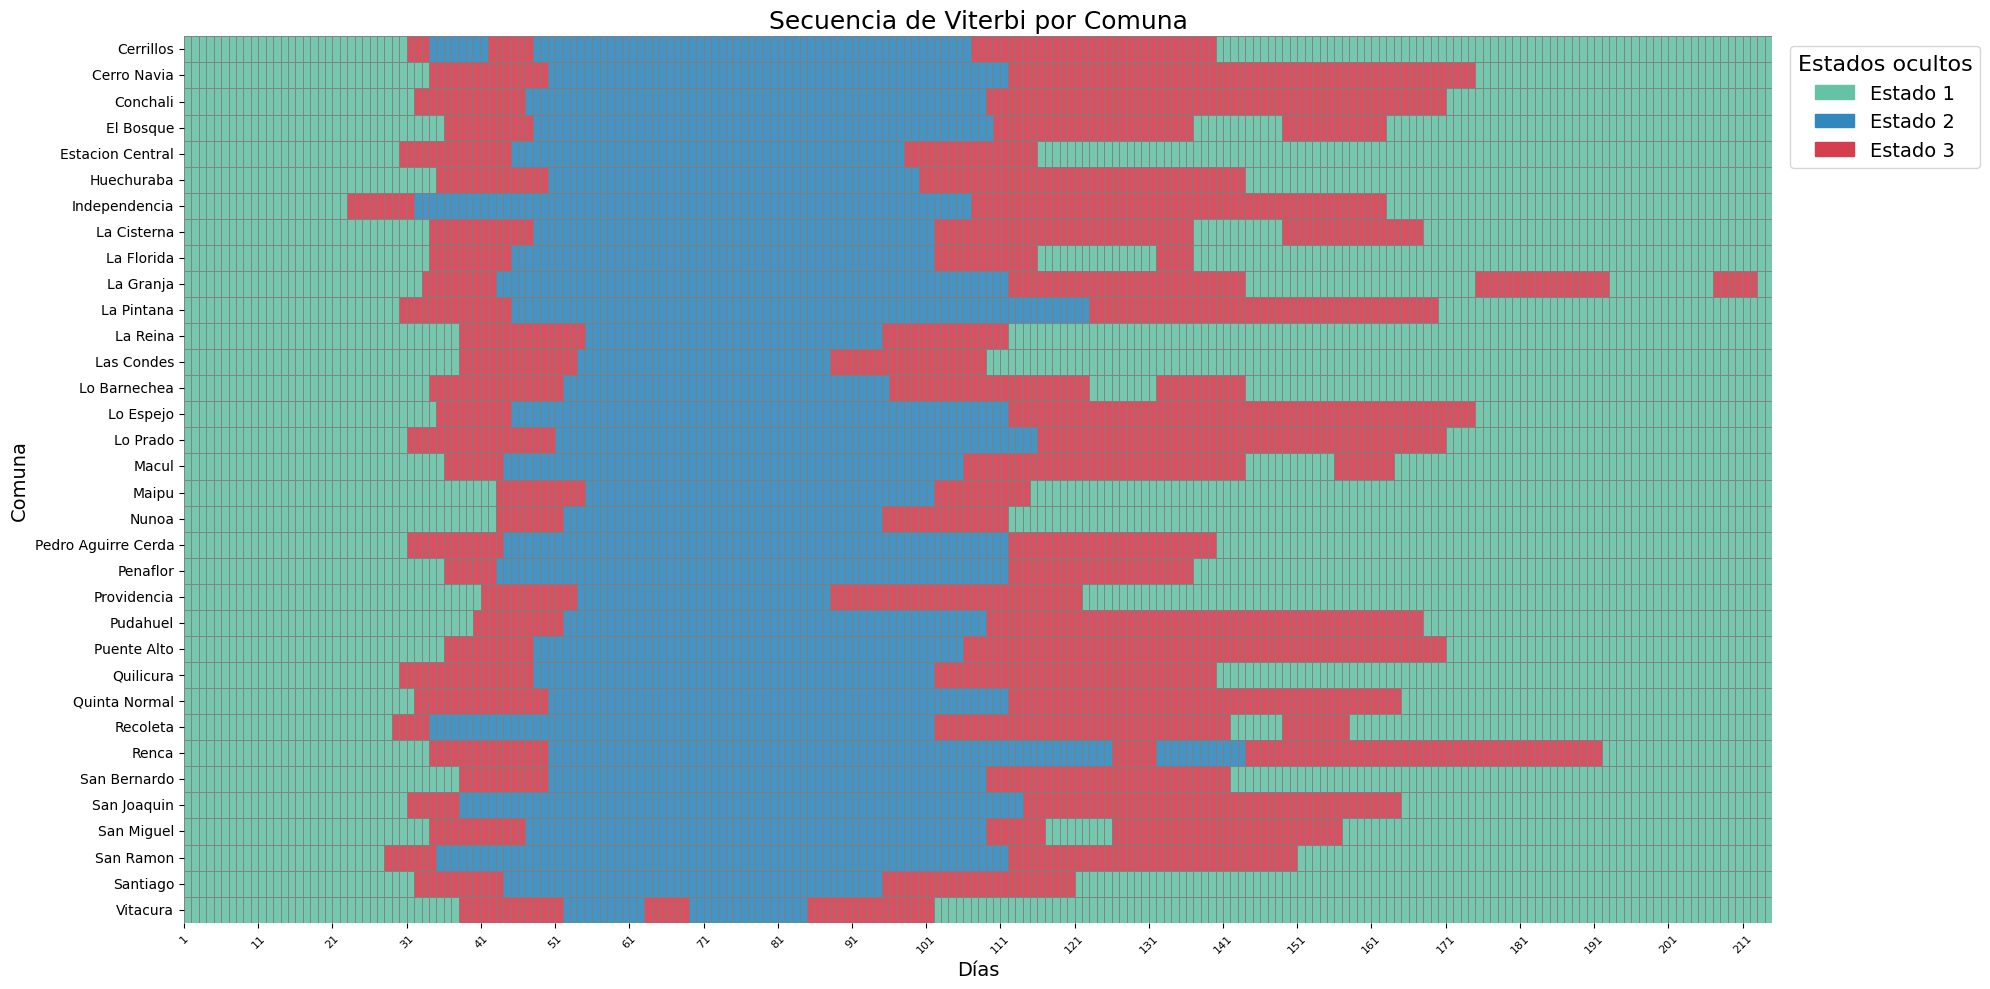

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Crear la tabla pivotada
viterbi_pivot = viterbi_merged.pivot(index='Commune', columns='Days', values='Reordened_state')

# Colores estilo "Nature" / ColorBrewer
custom_colors = ['#66c2a5', '#3288bd', '#d53e4f']  # Estado 1, 2, 3

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    viterbi_pivot,
    cmap=sns.color_palette(custom_colors, as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    alpha=0.9,
    cbar=False,
    ax=ax
)

# Ejes
ax.set_ylabel("Comuna", fontsize=14)
ax.set_xlabel("Días", fontsize=14)

# Etiquetas del eje X: mostrar solo cada 10 días
ax.set_xticks(range(0, len(viterbi_pivot.columns), 10))
ax.set_xticklabels(range(1, len(viterbi_pivot.columns)+1, 10), rotation=45, fontsize=8)

# Crear leyenda personalizada
legend_labels = ['Estado 1', 'Estado 2', 'Estado 3']
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(custom_colors, legend_labels)]

plt.legend(
    handles=legend_handles,
    title="Estados ocultos",
    bbox_to_anchor=(1.005, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16
)

# Título del gráfico
plt.title('Secuencia de Viterbi por Comuna', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()


### Validación con 4 estados

In [36]:
# Ajustar modelo HMM con 4 estados
hmm_model_4 = depmixS4.depmix(
    response=hmm_formula,
    nstates=4,  # ahora 4 estados
    family=gaussian_family,
    data=covid_data_r,
    transition=trans_formula,
    ntimes=ntimes
)

hmm_fitted_4 = depmixS4.fit(hmm_model_4)

print("\nAdjusted HMM model (4 estados):")
print(hmm_fitted_4)


converged at iteration 222 with logLik: -20448.6 

Adjusted HMM model (4 estados):
Convergence info: Log likelihood converged to within tol. (relative change) 
'log Lik.' -20448.6 (df=443)
AIC:  41783.21 
BIC:  44836.52 



In [37]:
# Viterbi para modelo de 4 estados
posterior_probs_4 = r['slot'](hmm_fitted_4, "posterior")
viterbi_df_4 = pandas2ri.rpy2py(posterior_probs_4).reset_index(drop=True)
viterbi_df_4['row_id'] = viterbi_df_4.index

# Juntar con los datos originales
viterbi_merged_4 = pd.merge(viterbi_df_4, covid_data, on='row_id', how='inner')

# Si quieres reordenar (esto depende de qué interpretación quieras darle):
# Aquí por ahora no hacemos remapeo, a menos que veamos que conviene.
viterbi_merged_4['Reordened_state'] = viterbi_merged_4['state']


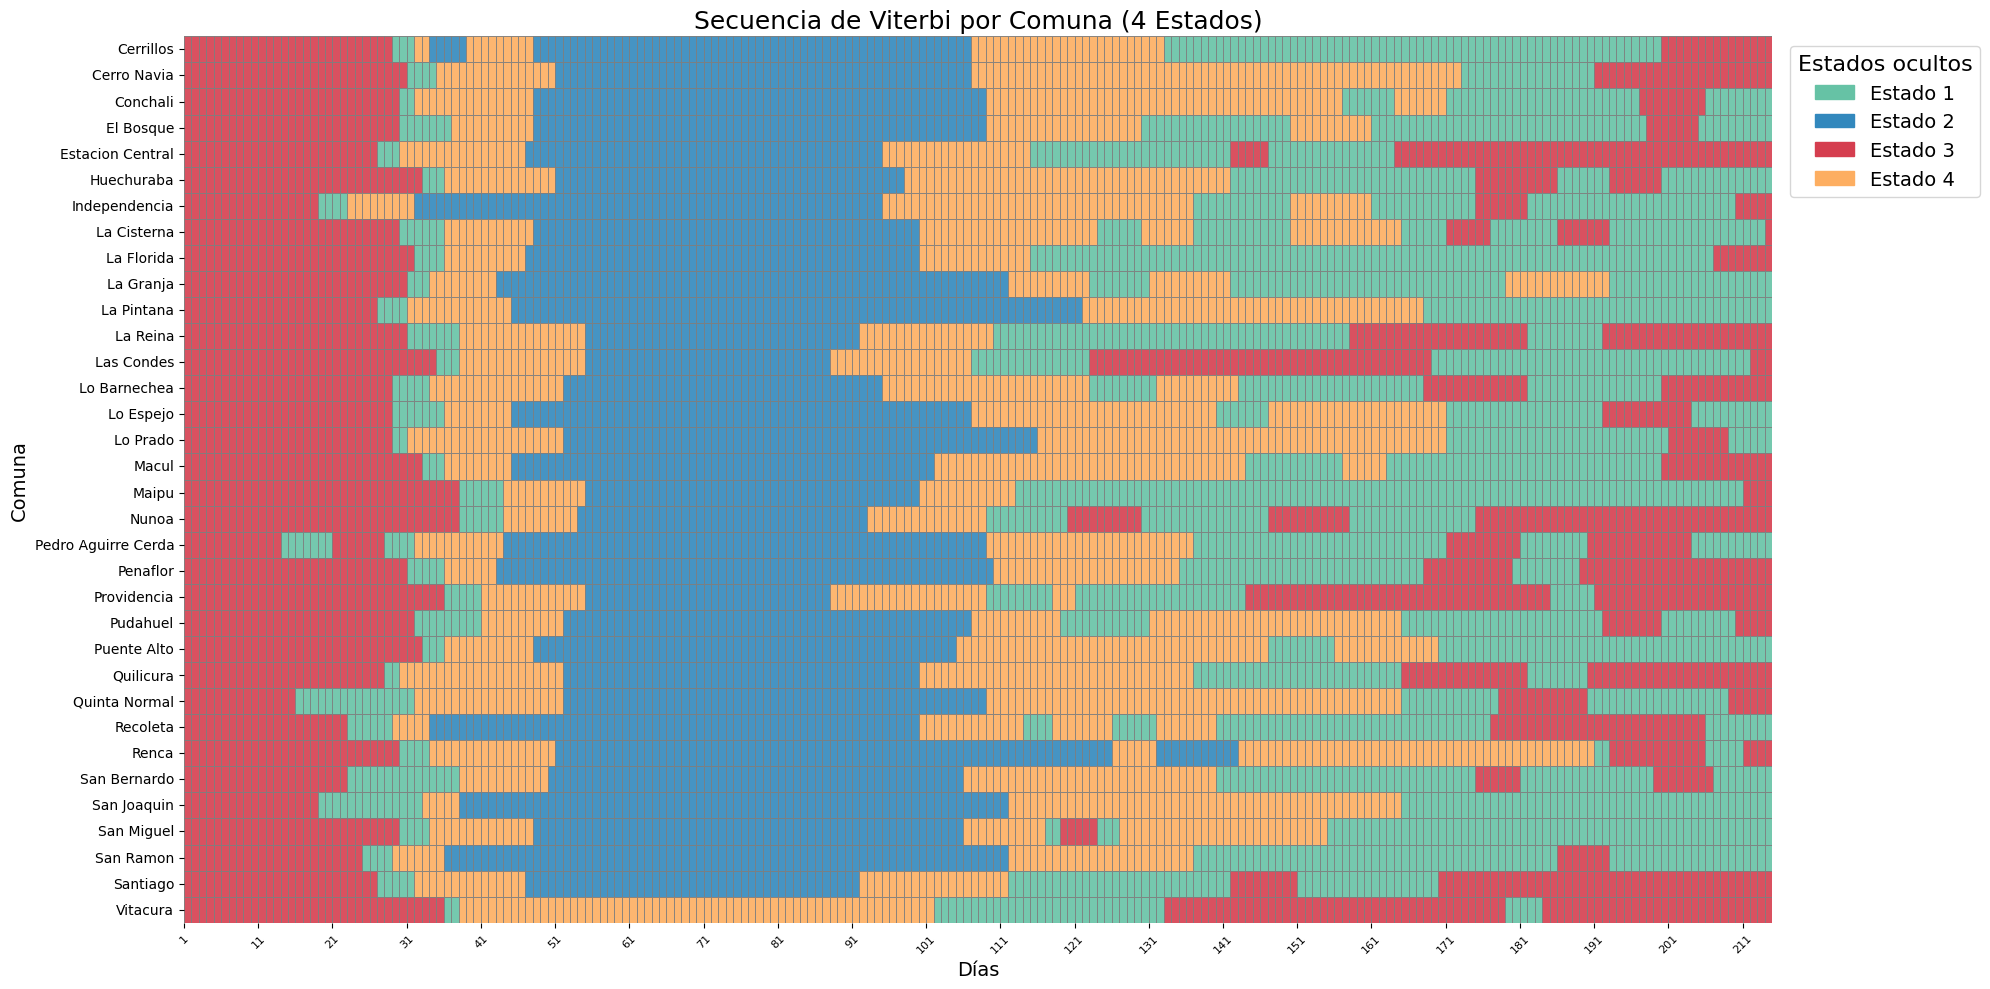

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Crear la tabla pivotada
viterbi_pivot_4 = viterbi_merged_4.pivot(index='Commune', columns='Days', values='Reordened_state')

# Colores estilo "Nature" / ColorBrewer (ahora para 4 estados)
custom_colors_4 = ['#66c2a5', '#3288bd', '#d53e4f', '#fdae61']  # Estado 1, 2, 3, 4

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    viterbi_pivot_4,
    cmap=sns.color_palette(custom_colors_4, as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    alpha=0.9,
    cbar=False,
    ax=ax
)

# Ejes
ax.set_ylabel("Comuna", fontsize=14)
ax.set_xlabel("Días", fontsize=14)

# Etiquetas del eje X: mostrar solo cada 10 días
ax.set_xticks(range(0, len(viterbi_pivot_4.columns), 10))
ax.set_xticklabels(range(1, len(viterbi_pivot_4.columns)+1, 10), rotation=45, fontsize=8)

# Crear leyenda personalizada
legend_labels_4 = ['Estado 1', 'Estado 2', 'Estado 3', 'Estado 4']
legend_handles_4 = [mpatches.Patch(color=color, label=label) for color, label in zip(custom_colors_4, legend_labels_4)]

plt.legend(
    handles=legend_handles_4,
    title="Estados ocultos",
    bbox_to_anchor=(1.005, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16
)

# Título del gráfico
plt.title('Secuencia de Viterbi por Comuna (4 Estados)', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()


### Validación con 5 estados

In [39]:
# Ajustar modelo HMM con 4 estados
hmm_model_5 = depmixS4.depmix(
    response=hmm_formula,
    nstates=5,  # ahora 5 estados
    family=gaussian_family,
    data=covid_data_r,
    transition=trans_formula,
    ntimes=ntimes
)

hmm_fitted_5 = depmixS4.fit(hmm_model_5)

print("\nAdjusted HMM model (5 estados):")
print(hmm_fitted_5)

converged at iteration 116 with logLik: -18959.39 

Adjusted HMM model (5 estados):
Convergence info: Log likelihood converged to within tol. (relative change) 
'log Lik.' -18959.39 (df=734)
AIC:  39386.77 
BIC:  44445.75 



In [40]:
# Viterbi para modelo de 4 estados
posterior_probs_5 = r['slot'](hmm_fitted_5, "posterior")
viterbi_df_5 = pandas2ri.rpy2py(posterior_probs_5).reset_index(drop=True)
viterbi_df_5['row_id'] = viterbi_df_5.index

# Juntar con los datos originales
viterbi_merged_5 = pd.merge(viterbi_df_5, covid_data, on='row_id', how='inner')

# Si quieres reordenar (esto depende de qué interpretación quieras darle):
# Aquí por ahora no hacemos remapeo, a menos que veamos que conviene.
viterbi_merged_5['Reordened_state'] = viterbi_merged_5['state']

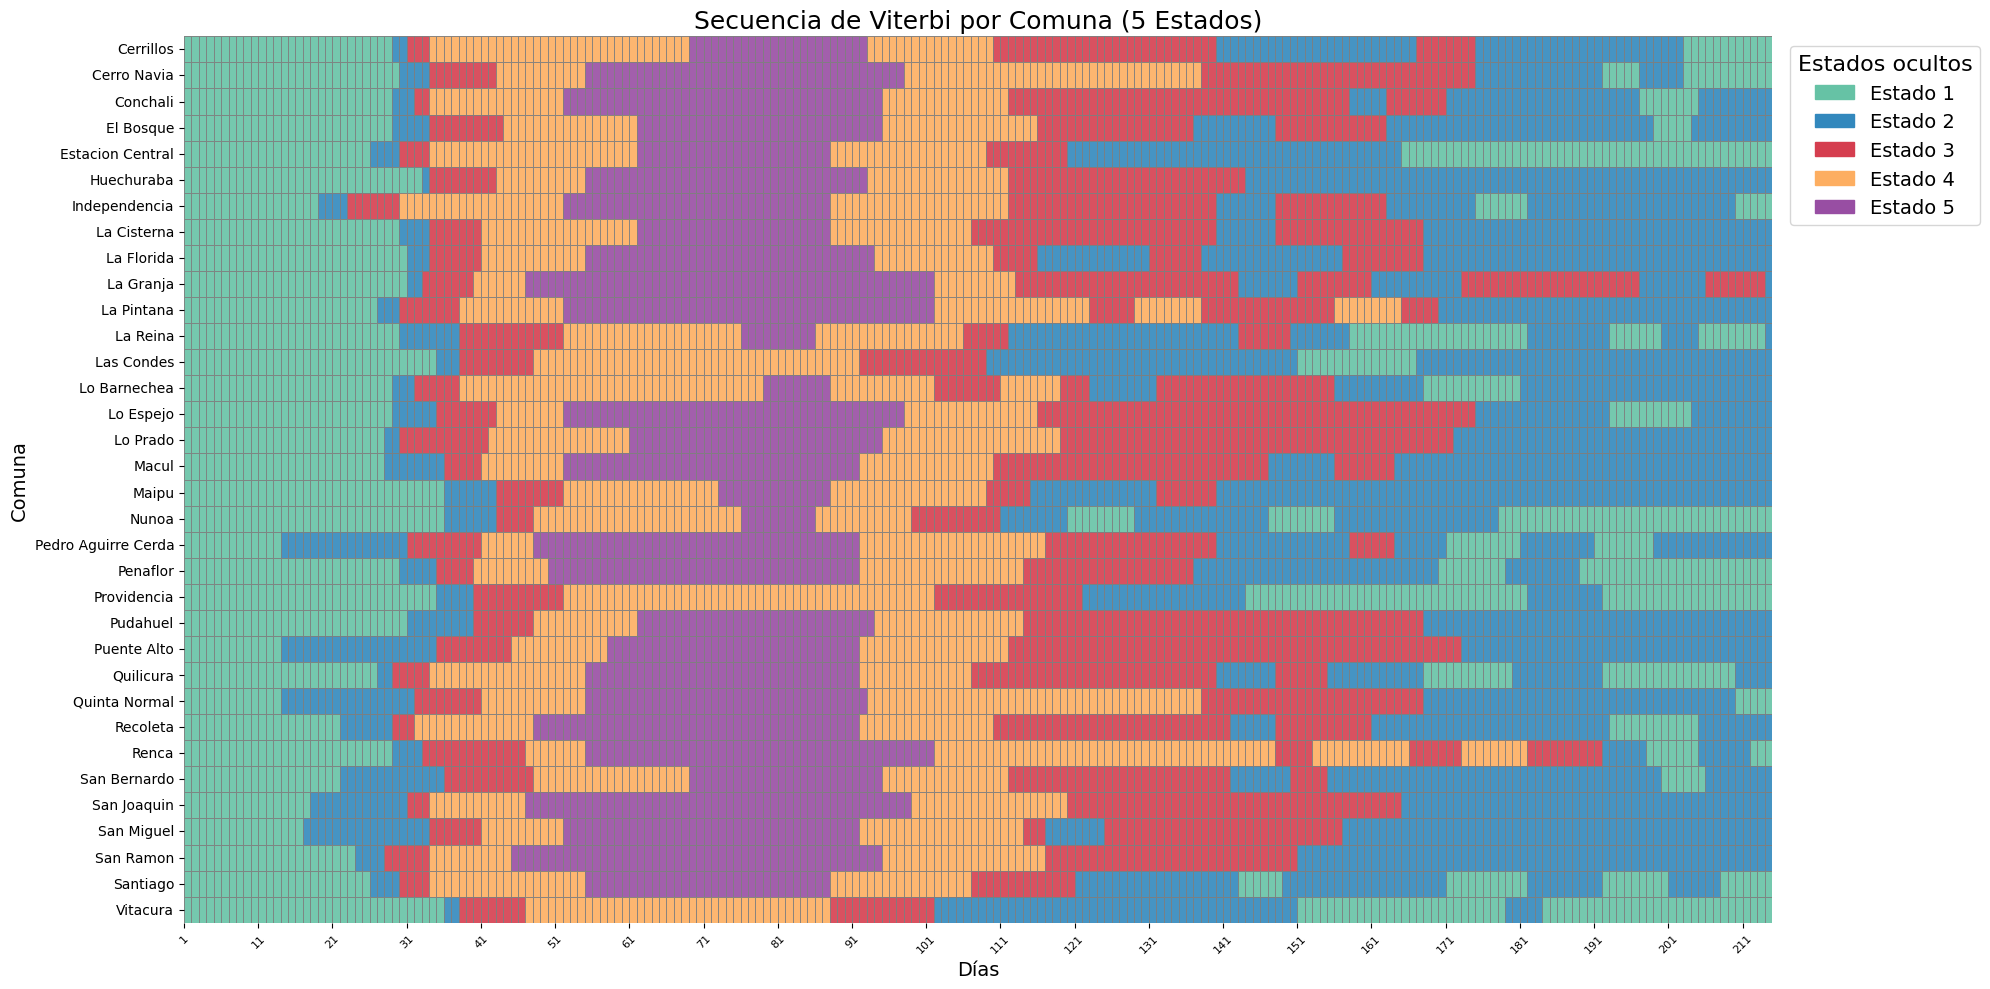

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Crear la tabla pivotada para 5 estados
viterbi_pivot_5 = viterbi_merged_5.pivot(index='Commune', columns='Days', values='Reordened_state')

# Definir paleta de colores para 5 estados
custom_colors_5 = ['#66c2a5', '#3288bd', '#d53e4f', '#fdae61', '#984ea3']  # Estado 1–5

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    viterbi_pivot_5,
    cmap=sns.color_palette(custom_colors_5, as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    alpha=0.9,
    cbar=False,
    ax=ax
)

# Etiquetas de los ejes
ax.set_ylabel("Comuna", fontsize=14)
ax.set_xlabel("Días", fontsize=14)

# Etiquetas X: cada 10 días
ax.set_xticks(range(0, len(viterbi_pivot_5.columns), 10))
ax.set_xticklabels(range(1, len(viterbi_pivot_5.columns)+1, 10), rotation=45, fontsize=8)

# Leyenda personalizada
legend_labels_5 = ['Estado 1', 'Estado 2', 'Estado 3', 'Estado 4', 'Estado 5']
legend_handles_5 = [mpatches.Patch(color=color, label=label) for color, label in zip(custom_colors_5, legend_labels_5)]

plt.legend(
    handles=legend_handles_5,
    title="Estados ocultos",
    bbox_to_anchor=(1.005, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16
)

# Título del gráfico
plt.title('Secuencia de Viterbi por Comuna (5 Estados)', fontsize=18)

# Mostrar
plt.tight_layout()
plt.show()


AIC y BIC bajan sistemáticamente al aumentar el número de estados. Desde el punto de vista estrictamente estadístico, el modelo de 5 estados es el mejor.

PERO BIC penaliza más la complejidad, y la diferencia entre 4 y 5 estados es menos notoria que entre 2 y 3 o 3 y 4. Es decir: la ganancia marginal es cada vez menor.

👁 Evaluación visual de los heatmaps
Modelo de 3 estados
Los estados tienen patrones bastante claros, transiciones coherentes, y reflejan fases distintas de la pandemia.

Es simple, fácil de interpretar, y permite comparaciones entre comunas.

Los estados parecen bien diferenciados, aunque algunos momentos podrían tener más granularidad.

Modelo de 4 estados
Se observa una mejora en la separación de fases transitorias: hay zonas que antes parecían homogéneas que ahora se separan en estados intermedios (especialmente en transiciones del centro del período).

La diferenciación adicional parece coherente y estable, no excesivamente fragmentada.

Buen equilibrio entre detalle y legibilidad.

Modelo de 5 estados
Se ve más fragmentación y ruido: transiciones más abruptas, cambios más frecuentes que podrían dificultar la interpretación.

Algunas comunas parecen “saltar” entre estados sin una progresión clara.

Esto podría reflejar ruido más que patrones reales (sobreajuste).

✅ Recomendación
El modelo de 4 estados parece ser la mejor opción globalmente, considerando:

Una mejora significativa en AIC/BIC respecto a 3 estados.

Un equilibrio entre detalle y estabilidad.

Coherencia visual en los patrones por comuna.

Evita el sobreajuste del modelo de 5 estados.

## Transition probabilites between states (4 estados)

In [42]:
# Extraer la matriz de transición del modelo de 4 estados
transition_matrix_4 = r['slot'](hmm_fitted_4, "trDens")

print("\nMatriz de transición ajustada (modelo 4 estados):")
print(transition_matrix_4)



Matriz de transición ajustada (modelo 4 estados):
[[[9.67525744e-01 8.02338491e-16 2.89871136e-02 4.45515282e-03]
  [8.19257547e-14 9.99093166e-01 1.33892346e-11 1.15373597e-02]
  [5.64505096e-03 1.43804868e-20 9.71012886e-01 2.68511757e-16]
  [2.68292045e-02 9.06833620e-04 5.36082793e-11 9.84007487e-01]]

 [[9.58211126e-01 1.82739222e-16 2.68985748e-02 2.80393039e-03]
  [3.21513310e-13 9.99644713e-01 2.66634587e-11 1.89085490e-02]
  [4.41927101e-03 1.48960108e-21 9.73101425e-01 6.91887871e-17]
  [3.73696033e-02 3.55287062e-04 8.63791717e-11 9.78287521e-01]]

 [[9.38904053e-01 1.76438995e-17 2.31878372e-02 1.26957372e-03]
  [2.79776819e-12 9.99924602e-01 8.04415776e-11 3.95980726e-02]
  [2.93418690e-03 4.06057083e-23 9.76812163e-01 7.42367138e-18]
  [5.81617598e-02 7.53983421e-05 1.78236916e-10 9.59132354e-01]]

 ...

 [[2.70940647e-01 3.54878633e-09 1.89677723e-02 9.95773637e-01]
  [3.94544009e-33 1.32639715e-25 2.98082247e-20 2.15325527e-19]
  [7.29059351e-01 9.98269374e-01 9.810322

In [43]:
import pandas as pd

# Reestructurar la matriz para obtener las transiciones por muestra
n_samples, n_states, _ = transition_matrix_4.shape

transitions_list_4 = []
for t in range(n_samples):
    for i in range(n_states):
        for j in range(n_states):
            transitions_list_4.append({
                "sample": t,
                f"Trans_{i+1}->{j+1}": transition_matrix_4[t, i, j]
            })

# Convertir a DataFrame
transitions_df_4 = pd.DataFrame(transitions_list_4).groupby("sample").mean().reset_index(drop=True)

# Mostrar una parte
print("Probabilidades estructuradas (modelo 4 estados):")
print(transitions_df_4.head())


Probabilidades estructuradas (modelo 4 estados):
   Trans_1->1    Trans_1->2  Trans_1->3  Trans_1->4    Trans_2->1  Trans_2->2  \
0    0.967526  8.023385e-16    0.028987    0.004455  8.192575e-14    0.999093   
1    0.958211  1.827392e-16    0.026899    0.002804  3.215133e-13    0.999645   
2    0.938904  1.764390e-17    0.023188    0.001270  2.797768e-12    0.999925   
3    0.945742  1.002602e-15    0.037763    0.007293  6.030750e-14    0.998115   
4    0.862202  8.485629e-19    0.021815    0.000538  4.207256e-11    0.999986   

     Trans_2->3  Trans_2->4  Trans_3->1    Trans_3->2  Trans_3->3  \
0  1.338923e-11    0.011537    0.005645  1.438049e-20    0.971013   
1  2.666346e-11    0.018909    0.004419  1.489601e-21    0.973101   
2  8.044158e-11    0.039598    0.002934  4.060571e-23    0.976812   
3  1.046356e-11    0.013820    0.006652  2.402059e-20    0.962237   
4  3.136668e-10    0.112259    0.001758  4.131405e-25    0.978185   

     Trans_3->4  Trans_4->1  Trans_4->2    Trans_

In [44]:
# Seleccionar las covariables relevantes
covariates_df_4 = viterbi_merged_4[[
    'Internal_Mobility_Index', 'External_Mobility_Index', 
    'Per_Capita_Income', 'Average_Household_Persons', 'Inmigrants', 
    'Total_Households_Housed', 'Housing_Precariousness_Index', 
    'Higher_Education_Percentage', 'Social_Priority_Index_2020'
]].reset_index(drop=True)

# Combinar con las probabilidades de transición
analysis_df_4 = pd.concat([covariates_df_4, transitions_df_4], axis=1)

# Mostrar un resumen
print("🔵 Data combinada para análisis (modelo 4 estados):")
print(analysis_df_4.head())


🔵 Data combinada para análisis (modelo 4 estados):
   Internal_Mobility_Index  External_Mobility_Index  Per_Capita_Income  \
0                 1.970381                 7.804008          267197.56   
1                 1.845790                 7.471452          267197.56   
2                 1.678598                 6.891732          267197.56   
3                 1.736766                 8.317872          267197.56   
4                 1.331296                 6.378498          267197.56   

   Average_Household_Persons  Inmigrants  Total_Households_Housed  \
0                   3.145581        3606                    68120   
1                   3.145581        3606                    68120   
2                   3.145581        3606                    68120   
3                   3.145581        3606                    68120   
4                   3.145581        3606                    68120   

   Housing_Precariousness_Index  Higher_Education_Percentage  \
0                      3.

In [45]:
# 🔵 Crear la lista de transiciones para 4 estados
transitions_list_4 = []

for idx, matriz in enumerate(transition_matrix_4):
    for from_state in range(len(matriz)):
        for to_state in range(len(matriz[from_state])):
            transitions_list_4.append({
                'Original_Day': viterbi_merged_4.iloc[idx]['Days'],  # Día original
                'Correlative_Day': idx,                               # Índice o correlativo
                'Commune': viterbi_merged_4.iloc[idx]['Commune'],     # Comuna
                'from_state': from_state + 1,
                'to_state': to_state + 1,
                'probability': matriz[from_state][to_state]
            })

# Crear el DataFrame
transitions_df_long_4 = pd.DataFrame(transitions_list_4)

# Crear la columna con el nombre de la transición
transitions_df_long_4['Transition'] = (
    "Trans_" + transitions_df_long_4['from_state'].astype(str) + "->" + transitions_df_long_4['to_state'].astype(str)
)

# Mostrar un resumen
print("🔵 DataFrame de transiciones (4 estados):")
print(transitions_df_long_4.head())


🔵 DataFrame de transiciones (4 estados):
   Original_Day  Correlative_Day    Commune  from_state  to_state  \
0             2                0  Cerrillos           1         1   
1             2                0  Cerrillos           1         2   
2             2                0  Cerrillos           1         3   
3             2                0  Cerrillos           1         4   
4             2                0  Cerrillos           2         1   

    probability  Transition  
0  9.675257e-01  Trans_1->1  
1  8.023385e-16  Trans_1->2  
2  2.898711e-02  Trans_1->3  
3  4.455153e-03  Trans_1->4  
4  8.192575e-14  Trans_2->1  


In [46]:
transitions_df_long_4.head()

,Original_Day,Correlative_Day,Commune,from_state,to_state,probability,Transition
0,2,0,Cerrillos,1,1,9.675257e-01,Trans_1->1
1,2,0,Cerrillos,1,2,8.023385e-16,Trans_1->2
2,2,0,Cerrillos,1,3,2.898711e-02,Trans_1->3
3,2,0,Cerrillos,1,4,4.455153e-03,Trans_1->4
4,2,0,Cerrillos,2,1,8.192575e-14,Trans_2->1


In [47]:
# Pivotear para tener transiciones como columnas
transitions_df_wide_4 = transitions_df_long_4.pivot(
    index=['Commune', 'Original_Day', 'Correlative_Day'],
    columns='Transition',
    values='probability'
).reset_index()

# Mostrar resultado
print("DataFrame pivotado de transiciones (formato ancho):")
print(transitions_df_wide_4.head())


DataFrame pivotado de transiciones (formato ancho):
Transition    Commune  Original_Day  Correlative_Day  Trans_1->1  \
0           Cerrillos             2                0    0.967526   
1           Cerrillos             3                1    0.958211   
2           Cerrillos             4                2    0.938904   
3           Cerrillos             5                3    0.945742   
4           Cerrillos             6                4    0.862202   

Transition    Trans_1->2  Trans_1->3  Trans_1->4    Trans_2->1  Trans_2->2  \
0           8.023385e-16    0.028987    0.004455  8.192575e-14    0.999093   
1           1.827392e-16    0.026899    0.002804  3.215133e-13    0.999645   
2           1.764390e-17    0.023188    0.001270  2.797768e-12    0.999925   
3           1.002602e-15    0.037763    0.007293  6.030750e-14    0.998115   
4           8.485629e-19    0.021815    0.000538  4.207256e-11    0.999986   

Transition    Trans_2->3  Trans_2->4  Trans_3->1    Trans_3->2  Trans_

In [48]:
# Convertir de wide a long
transitions_long_4 = pd.melt(
    transitions_df_wide_4,
    id_vars=['Commune', 'Original_Day', 'Correlative_Day'],
    value_vars=['Trans_1->1', 'Trans_1->2', 'Trans_1->3', 'Trans_1->4',
                'Trans_2->1', 'Trans_2->2', 'Trans_2->3', 'Trans_2->4',
                'Trans_3->1', 'Trans_3->2', 'Trans_3->3', 'Trans_3->4',
                'Trans_4->1', 'Trans_4->2', 'Trans_4->3', 'Trans_4->4'],
    var_name='Transition',
    value_name='Probability_Transition'
)

# Unir con covariables
lmm_data_4 = transitions_long_4.merge(
    viterbi_merged_4[['Commune', 'Days', 'Internal_Mobility_Index', 'External_Mobility_Index', 'Cumulative_Cases_Rate',
                      'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 'Per_Capita_Income',
                      'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
                      'Housing_Precariousness_Index', 'Higher_Education_Percentage', 'Social_Priority_Index_2020']],
    left_on=['Commune', 'Original_Day'],
    right_on=['Commune', 'Days'],
    how='left'
)

# Mostrar resultado
print("Datos finales preparados para LMM:")
print(lmm_data_4.head())


Datos finales preparados para LMM:
     Commune  Original_Day  Correlative_Day  Transition  \
0  Cerrillos             2                0  Trans_1->1   
1  Cerrillos             3                1  Trans_1->1   
2  Cerrillos             4                2  Trans_1->1   
3  Cerrillos             5                3  Trans_1->1   
4  Cerrillos             6                4  Trans_1->1   

   Probability_Transition  Days  Internal_Mobility_Index  \
0                0.967526     2                 1.970381   
1                0.958211     3                 1.845790   
2                0.938904     4                 1.678598   
3                0.945742     5                 1.736766   
4                0.862202     6                 1.331296   

   External_Mobility_Index  Cumulative_Cases_Rate  Gross_Daily_Cases  \
0                 7.804008               2.248303           2.248303   
1                 7.471452               4.496605           2.248303   
2                 6.891732       

In [49]:
lmm_data_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116416 entries, 0 to 116415
Data columns (total 18 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Commune                                  116416 non-null  object 
 1   Original_Day                             116416 non-null  int64  
 2   Correlative_Day                          116416 non-null  int64  
 3   Transition                               116416 non-null  object 
 4   Probability_Transition                   116416 non-null  float64
 5   Days                                     116416 non-null  int64  
 6   Internal_Mobility_Index                  116416 non-null  float64
 7   External_Mobility_Index                  116416 non-null  float64
 8   Cumulative_Cases_Rate                    116416 non-null  float64
 9   Gross_Daily_Cases                        116416 non-null  float64
 10  Gross_Daily_Cases_Mobile_Average

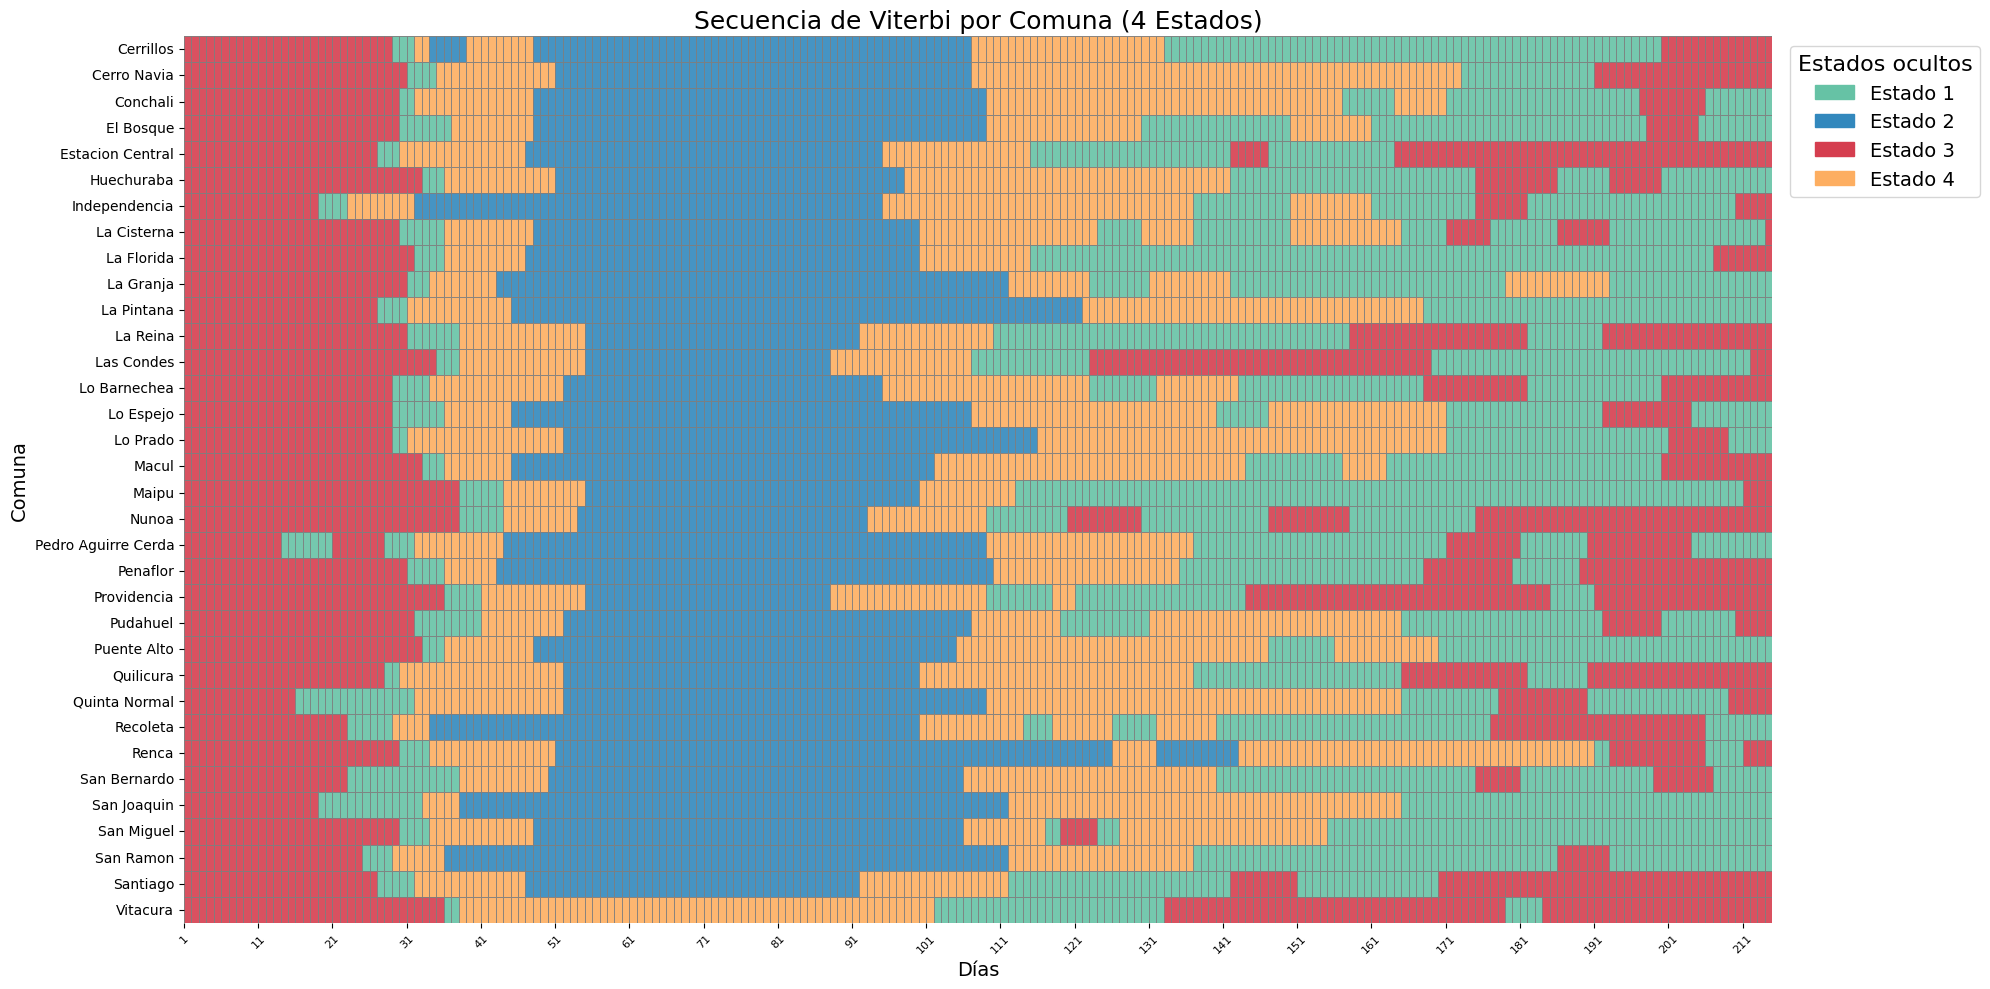

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Crear la tabla pivotada
viterbi_pivot_4 = viterbi_merged_4.pivot(index='Commune', columns='Days', values='Reordened_state')

# Colores estilo "Nature" / ColorBrewer (ahora para 4 estados)
custom_colors_4 = ['#66c2a5', '#3288bd', '#d53e4f', '#fdae61']  # Estado 1, 2, 3, 4

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    viterbi_pivot_4,
    cmap=sns.color_palette(custom_colors_4, as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    alpha=0.9,
    cbar=False,
    ax=ax
)

# Ejes
ax.set_ylabel("Comuna", fontsize=14)
ax.set_xlabel("Días", fontsize=14)

# Etiquetas del eje X: mostrar solo cada 10 días
ax.set_xticks(range(0, len(viterbi_pivot_4.columns), 10))
ax.set_xticklabels(range(1, len(viterbi_pivot_4.columns)+1, 10), rotation=45, fontsize=8)

# Crear leyenda personalizada
legend_labels_4 = ['Estado 1', 'Estado 2', 'Estado 3', 'Estado 4']
legend_handles_4 = [mpatches.Patch(color=color, label=label) for color, label in zip(custom_colors_4, legend_labels_4)]

plt.legend(
    handles=legend_handles_4,
    title="Estados ocultos",
    bbox_to_anchor=(1.005, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16
)

# Título del gráfico
plt.title('Secuencia de Viterbi por Comuna (4 Estados)', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()

### Remapeo para interpretación

In [53]:
# Crear diccionario de remapeo
remap_4estados = {3: 1, 1: 2, 4: 3, 2: 4}

# Aplicar remapeo
viterbi_merged_4['Reordened_state'] = viterbi_merged_4['state'].map(remap_4estados)


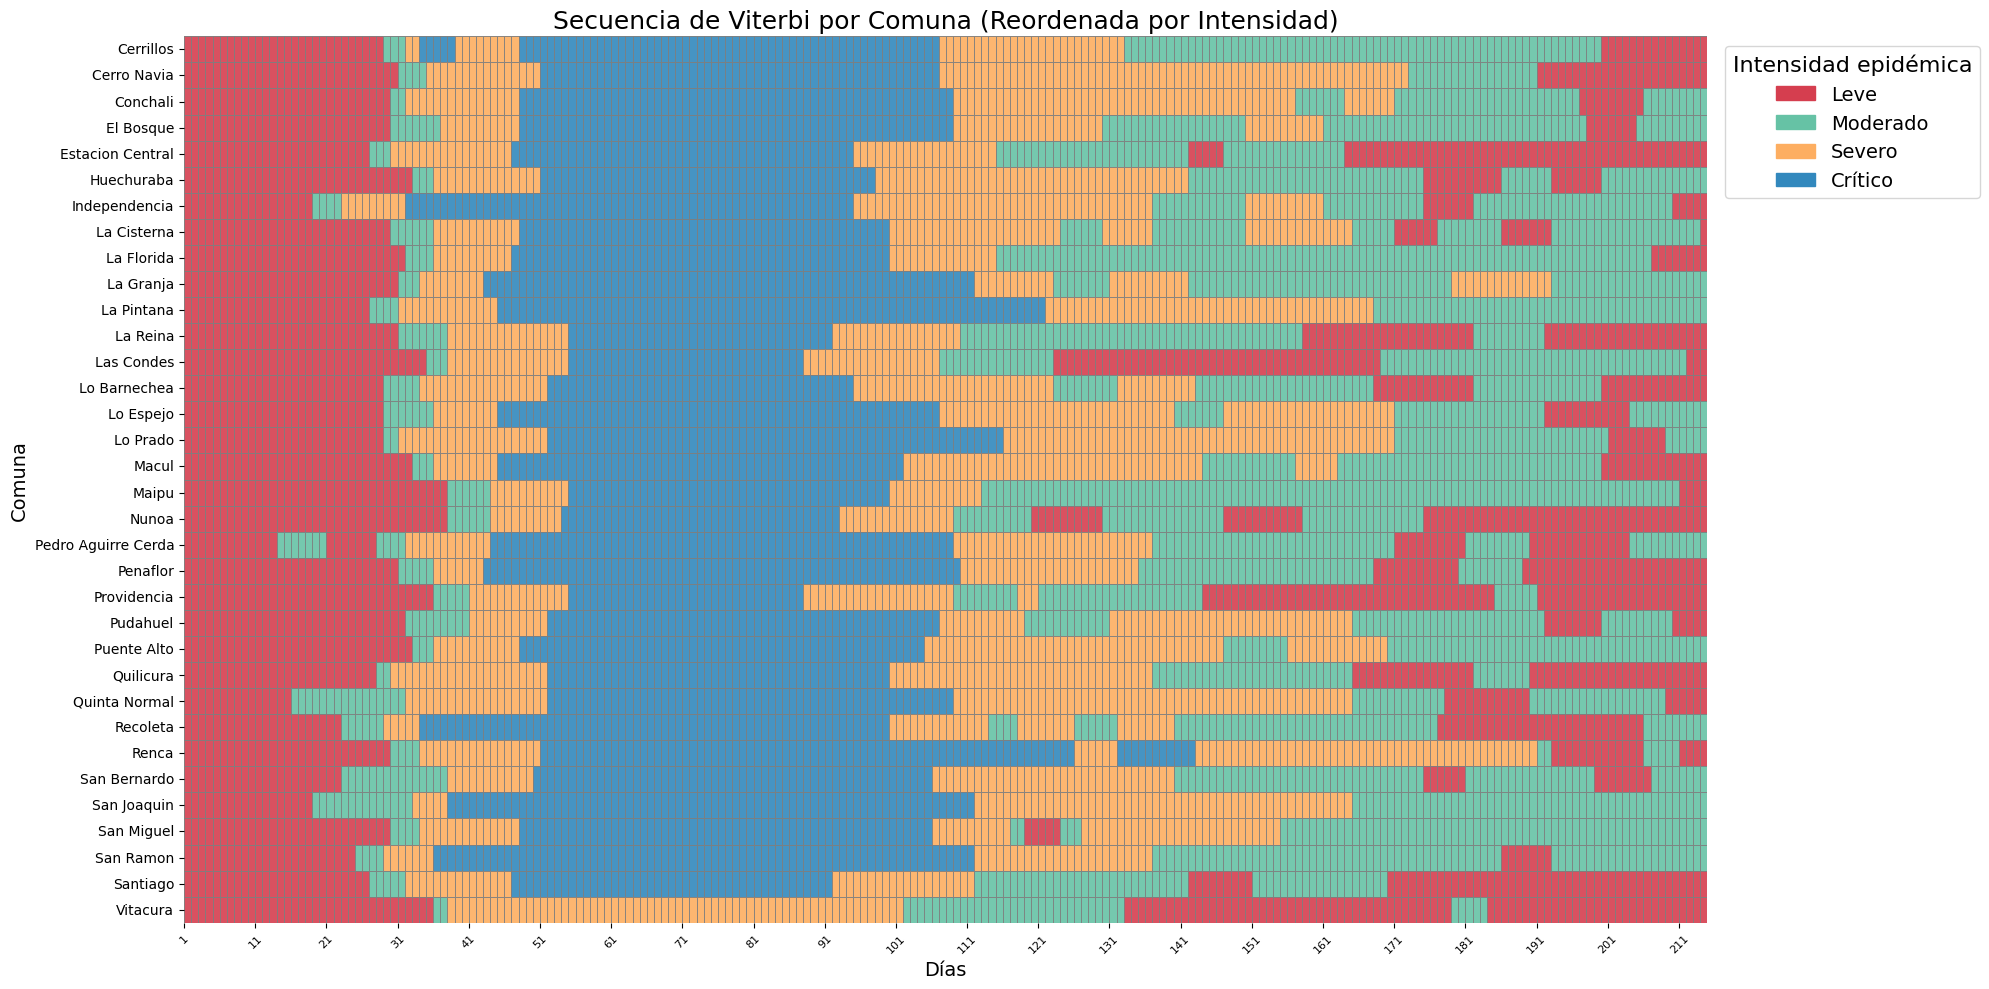

In [54]:
# Tabla pivotada actualizada
viterbi_pivot_4 = viterbi_merged_4.pivot(index='Commune', columns='Days', values='Reordened_state')

# Reorganizamos los colores en el nuevo orden deseado
custom_colors_4 = ['#d53e4f', '#66c2a5', '#fdae61', '#3288bd']  # leve, moderado, severo, crítico

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    viterbi_pivot_4,
    cmap=sns.color_palette(custom_colors_4, as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    alpha=0.9,
    cbar=False,
    ax=ax
)

# Ejes
ax.set_ylabel("Comuna", fontsize=14)
ax.set_xlabel("Días", fontsize=14)

ax.set_xticks(range(0, len(viterbi_pivot_4.columns), 10))
ax.set_xticklabels(range(1, len(viterbi_pivot_4.columns)+1, 10), rotation=45, fontsize=8)

legend_labels_4 = ['Leve', 'Moderado', 'Severo', 'Crítico']
legend_handles_4 = [mpatches.Patch(color=color, label=label) for color, label in zip(custom_colors_4, legend_labels_4)]

plt.legend(
    handles=legend_handles_4,
    title="Intensidad epidémica",
    bbox_to_anchor=(1.005, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16
)

plt.title('Secuencia de Viterbi por Comuna (Reordenada por Intensidad)', fontsize=18)
plt.tight_layout()
plt.show()


In [55]:
# Crear función para transformar nombres de transición según remapeo
def remap_transition_label(transition_str, remap_dict):
    orig = transition_str.split("->")
    new_from = remap_dict[int(orig[0].split("_")[1])]
    new_to = remap_dict[int(orig[1])]
    return f"Trans_{new_from}->{new_to}"

# Aplicar a la columna Transition
lmm_data_4['Transition'] = lmm_data_4['Transition'].apply(lambda x: remap_transition_label(x, remap_4estados))


In [59]:
print("Transiciones únicas en lmm_data_4:")
print(sorted(lmm_data_4['Transition'].unique()))



Transiciones únicas en lmm_data_4:
['Trans_1->1', 'Trans_1->2', 'Trans_1->3', 'Trans_1->4', 'Trans_2->1', 'Trans_2->2', 'Trans_2->3', 'Trans_2->4', 'Trans_3->1', 'Trans_3->2', 'Trans_3->3', 'Trans_3->4', 'Trans_4->1', 'Trans_4->2', 'Trans_4->3', 'Trans_4->4']


## LMM para 4 estados